# Дипломный проект. Рекомендательная система

Нужно помочь клиенту (компания-ритейлер) повысить прибыль от допродаж в интернет-магазине на 20%!

Способ - сделать рекомендации прямо на главной, чтобы человек видел их сразу.  
У нас только три места для показа товаров, значит техническая метрика качества - Precision@3.

Заранее импортируем библиотеки, которые нам понадобятся для решения задачи:

In [ ]:
# загрузка библиотек
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import scipy
import xgboost as xgb
import sklearn
import surprise
import joblib

from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans
from collections import defaultdict
from lightfm import LightFM
from lightfm.evaluation import precision_at_k

%matplotlib inline
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

## Исследование данных


**events — датасет с событиями. Колонки:**
* timestamp — время события
* visitorid — идентификатор пользователя
* event — тип события
* itemid — идентификатор объекта
* transactionid — идентификатор транзакции, если она проходила

In [ ]:
events = pd.read_csv('/content/drive/MyDrive/events.csv')
display(events.head())
print('Записей событий:', events.shape[0])
print('Типы событий:', events['event'].unique())

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


Записей событий: 2756101
Типы событий: ['view' 'addtocart' 'transaction']


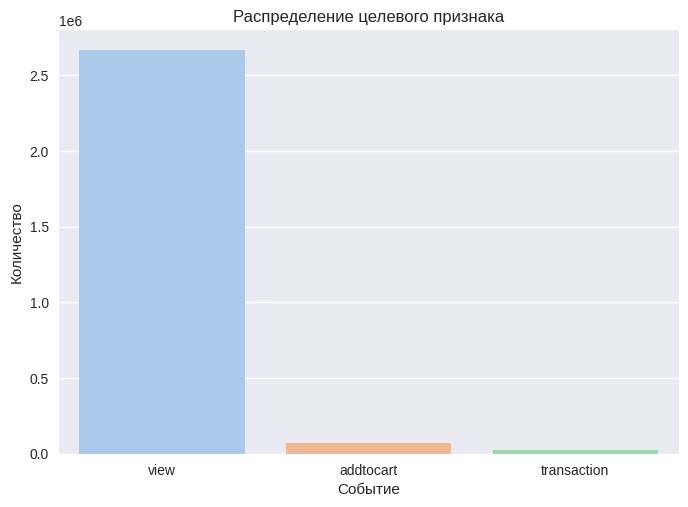

In [ ]:
# проверяем сбалансированность событий
countplot = sns.countplot(data = events, x = 'event', palette = 'pastel')
countplot.set_title('Распределение целевого признака')
countplot.set_xlabel('Событие')
countplot.set_ylabel('Количество');

**category_tree — файл с деревом категорий (можно восстановить дерево).**
* category_id — идентификатор категорий
* parent_id — идентификатор родительской категории

In [ ]:
category_tree = pd.read_csv('/content/drive/MyDrive/category_tree.csv')
category_tree.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


**item_properties — файл со свойствами товаров.**
* timestamp — момент записи значения свойства
* item_id — идентификатор объекта
* property — свойство, кажется, они все, кроме категории, захешированы
* value — значение свойства

In [ ]:
item_properties_part1 = pd.read_csv(
    '/content/drive/MyDrive/item_properties_part1.csv'
)
item_properties_part2 = pd.read_csv(
    '/content/drive/MyDrive/item_properties_part2.csv'
)
item_properties = pd.concat(
    [item_properties_part1, item_properties_part2]
).reset_index(drop = True)
display(item_properties.head())
print('Уникальных свойств:', item_properties['property'].nunique())

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


Уникальных свойств: 1104


Значение categoryid в свойствах заменим на идентификатор родительской категории.

In [ ]:
# добавляем к таблице свойств колонки с идентификаторами
item_properties = item_properties.merge(
    category_tree.astype('Int64').astype(str),
    how = 'left',
    left_on = 'value',
    right_on = 'categoryid'
)

# переименовываем родительские категории, чтобы не было совпадений
item_properties['parentid'] = 'parentid' + item_properties['parentid']

# заменяем значение categoryid
item_properties.loc[
    item_properties['property'] == 'categoryid',
    'property'
] = item_properties['parentid']

# удаляем колонки с идентификаторами
item_properties.drop(['categoryid', 'parentid'], axis = 1, inplace = True)

Проверим какое качество рекомендаций получится, если мы всем будем рекомендовать топовые товары. Возьмём статистику до 1 июля включительно и потом прикинем, какой процент продаж обеспечивают топовые товары. Для расчёта используем топ-3 товаров по числу транзакций.

In [ ]:
# переводим временную метку к формату datetime
events['timestamp'] = pd.to_datetime(events['timestamp'], unit = 'ms')
print('Min date:', events['timestamp'].min().date())
print('Max date:', events['timestamp'].max().date())

Min date: 2015-05-03
Max date: 2015-09-18


In [ ]:
# разделяем по точке отсечения и оставляем только транзакции
train_events = events[
    (events['timestamp'] < '2015-07-02')
    & (events['event'] == 'transaction')
]
test_events = events[
    (events['timestamp'] >= '2015-07-02')
    & (events['event'] == 'transaction')
]

# выявляем топ-3 товара по числу транзакций
top_3 = train_events['itemid'].value_counts()[:3].index

# рассчитываем процент продаж
sales_percentage = len(
    test_events[test_events['itemid'].isin(top_3)]
) / len(test_events) * 100
print(f'Процент продаж: {round(sales_percentage, 2)}%')

Процент продаж: 0.61%


## Очистка данных

Перекодируем события следующим образом:
* 1 - просмотр,
* 2 - добавление в корзину,
* 3 - покупка.

In [ ]:
def encode_event(event_type):
    if event_type == 'view':
        return 1
    elif event_type == 'addtocart':
        return 2
    else:
        return 3

events['event'] = events['event'].apply(encode_event)

In [ ]:
# создаём временные признаки
events['weekday'] = events['timestamp'].dt.weekday
events['month'] = events['timestamp'].dt.month
events['day'] = events['timestamp'].dt.day
events['hour'] = events['timestamp'].dt.hour
events['minute'] = events['timestamp'].dt.minute


def get_time_period(hour):
    """Функция агрегирует часы в часть суток."""

    if hour >= 3 and hour < 7:
        return 'dawn'
    elif hour >= 7 and hour < 12:
        return 'morning'
    elif hour >= 12 and hour < 16:
        return 'afternoon'
    elif hour >= 16 and hour < 22:
        return 'evening'
    else:
        return 'night'


events['day_period'] = events['hour'].apply(get_time_period)
display(events['day_period'].value_counts())
events = pd.get_dummies(events, prefix = '', prefix_sep = '', dtype = 'int')

,count
day_period,
evening,1078199
night,765924
dawn,494588
afternoon,293490
morning,123900


In [ ]:
# сортируем по временной метке
events.sort_values(by = 'timestamp', inplace = True)
events.reset_index(drop = True, inplace = True)

# удаляем дубликаты
subset_cols = [
    'visitorid',
    'event',
    'itemid',
    'weekday',
    'month',
    'day',
    'hour',
    'minute'
]
print('Количество удалённых дубликатов:', events.duplicated(subset_cols).sum())
events.drop_duplicates(subset_cols, inplace = True)

Количество удалённых дубликатов: 58915


Уберём малоактивных пользователей. Оставим только тех, которые купили более 3 уникальных продуктов.  
Также удалим неинформативный признак - transactionid (99% пропусков).

In [ ]:
# убираем малоактивных пользователей
user_activity = (
    events[events['event'] == 3]
    .groupby('visitorid')['itemid']
    .nunique()
)
active_users = user_activity[user_activity > 3].index
events = events[events['visitorid'].isin(active_users)]

# удаляем неинформативный признак
events = events.drop('transactionid', axis = 1)
print('Размер датасета:', events.shape)

Размер датасета: (108003, 14)


## Создание факторов для модели

### Генерация факторов, связанных с айтемами
Посмотрим на самые распространённые свойства айтемов, например топ-20 (при построении модели можно будет поиграть).

In [ ]:
top_properties = (
    item_properties
    .drop_duplicates(['itemid', 'property'])
    .groupby('property')['itemid']
    .count()
    .sort_values(ascending = False)[:20]
)
top_properties.index

Index(['159', '112', '283', 'available', '364', '888', '790', '764', '678',
       '917', '202', '6', '776', '839', '227', '698', '689', '28', '928',
       '348'],
      dtype='object', name='property')

Отфильтруем файл со свойствами товаров, оставив только топовые.

In [ ]:
properties_filtered = item_properties[
    item_properties['property']
    .isin(top_properties.index)
]
display(properties_filtered.head(10))
print('Shape:', properties_filtered.shape)

,timestamp,itemid,property,value
1,1441508400000,206783,888,1116713 960601 n277.200
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513
5,1436065200000,285026,available,0
7,1431831600000,264312,6,319724
8,1433646000000,229370,202,1330310
10,1439089200000,450113,888,1038400 45956 n504.000
12,1439694000000,264319,227,1283144 353870
13,1439694000000,348323,839,1026952 1162729
14,1434250800000,169055,790,n21000.000


Shape: (12888758, 4)


Добавим топовые свойства продуктов в датасет и закодируем бинарными признаками.

In [ ]:
# группируем свойства по itemid
property_lists = (
    properties_filtered
    .groupby('itemid', as_index = False)['property']
    .unique()
)

# добавляем список свойств в датасет
events = pd.merge(events, property_lists, how = 'left', on = 'itemid')
events['property'].fillna('[]', inplace = True)

# кодируем признаки
for value in top_properties.index:
    events[value] = (
        events['property']
        .apply(lambda x: 1 if value in x else 0)
    )

# удаляем признак со списками
events.drop('property', axis = 1, inplace = True)

Разбиваем датасет с событиями на тренировочный и валидационный.

In [ ]:
# разбиваем не перемешивая
train, test = sklearn.model_selection.train_test_split(
    events,
    test_size = 0.3,
    shuffle = False
)
print('Max train date/time:', train['timestamp'].max())
print('Min test  date/time:', test['timestamp'].min())

Max train date/time: 2015-07-30 02:31:59.651000
Min test  date/time: 2015-07-30 02:32:01.670000


## Генерация факторов item-user
Создаём юзер факторы.

In [ ]:
# общие количества просмотров, добавлений в корзину и покупок
user_total_view = (
    train[train['event'] == 1]
    .groupby('visitorid', as_index = False)['itemid']
    .count()
    .rename(columns = {'itemid': 'user_total_view'})
)
user_total_addtocart = (
    train[train['event'] == 2]
    .groupby('visitorid', as_index = False)['itemid']
    .count()
    .rename(columns = {'itemid': 'user_total_addtocart'})
)
user_total_transaction = (
    train[train['event'] == 3]
    .groupby('visitorid', as_index = False)['itemid']
    .count()
    .rename(columns = {'itemid': 'user_total_transaction'})
)

# количества уникальных просмотров, добавлений в корзину и покупок
user_unique_view = (
    train[train['event'] == 1]
    .groupby('visitorid', as_index = False)['itemid']
    .nunique()
    .rename(columns = {'itemid': 'user_unique_view'})
)
user_unique_addtocart = (
    train[train['event'] == 2]
    .groupby('visitorid', as_index = False)['itemid']
    .nunique()
    .rename(columns = {'itemid': 'user_unique_addtocart'})
)
user_unique_transaction = (
    train[train['event'] == 3]
    .groupby('visitorid', as_index = False)['itemid']
    .nunique()
    .rename(columns = {'itemid': 'user_unique_transaction'})
)

# объединяем в одну таблицу
user_statistics = pd.merge(
    user_total_view,
    user_total_addtocart,
    how = 'outer',
    on = 'visitorid'
)
user_statistics = pd.merge(
    user_statistics,
    user_total_transaction,
    how = 'outer',
    on = 'visitorid'
)
user_statistics = pd.merge(
    user_statistics,
    user_unique_view,
    how = 'outer',
    on = 'visitorid'
)
user_statistics = pd.merge(
    user_statistics,
    user_unique_addtocart,
    how = 'outer',
    on = 'visitorid'
)
user_statistics = pd.merge(
    user_statistics,
    user_unique_transaction,
    how = 'outer',
    on = 'visitorid'
)

# заполняем пропуски нулями и меняем тип
user_statistics.fillna(0, inplace = True)
user_statistics = user_statistics.astype(int)

# добавляем user факторы
train = pd.merge(train, user_statistics, how = 'left', on = 'visitorid')
test = pd.merge(test, user_statistics, how = 'left', on = 'visitorid')
test.fillna(0, inplace = True)
test = test.astype(int)

Создаём айтем факторы.

In [ ]:
# общие количества просмотров, добавлений в корзину и покупок
item_total_view = (
    train[train['event'] == 1]
    .groupby('itemid', as_index = False)['visitorid']
    .count()
    .rename(columns = {'visitorid': 'item_total_view'})
)
item_total_addtocart = (
    train[train['event'] == 2]
    .groupby('itemid', as_index = False)['visitorid']
    .count()
    .rename(columns = {'visitorid': 'item_total_addtocart'})
)
item_total_transaction = (
    train[train['event'] == 3]
    .groupby('itemid', as_index = False)['visitorid']
    .count()
    .rename(columns = {'visitorid': 'item_total_transaction'})
)

# количества уникальных просмотров, добавлений в корзину и покупок
item_unique_view = (
    train[train['event'] == 1]
    .groupby('itemid', as_index = False)['visitorid']
    .nunique()
    .rename(columns = {'visitorid': 'item_unique_view'})
)
item_unique_addtocart = (
    train[train['event'] == 2]
    .groupby('itemid', as_index = False)['visitorid']
    .nunique()
    .rename(columns = {'visitorid': 'item_unique_addtocart'})
)
item_unique_transaction = (
    train[train['event'] == 3]
    .groupby('itemid', as_index = False)['visitorid']
    .nunique()
    .rename(columns = {'visitorid': 'item_unique_transaction'})
)

# объединяем в одну таблицу
item_statistics = pd.merge(
    item_total_view,
    item_total_addtocart,
    how = 'outer',
    on = 'itemid'
)
item_statistics = pd.merge(
    item_statistics,
    item_total_transaction,
    how = 'outer',
    on = 'itemid'
)
item_statistics = pd.merge(
    item_statistics,
    item_unique_view,
    how = 'outer',
    on = 'itemid'
)
item_statistics = pd.merge(
    item_statistics,
    item_unique_addtocart,
    how = 'outer',
    on = 'itemid'
)
item_statistics = pd.merge(
    item_statistics,
    item_unique_transaction,
    how = 'outer',
    on = 'itemid'
)

# заполняем пропуски нулями и меняем тип
item_statistics.fillna(0, inplace = True)
item_statistics = item_statistics.astype(int)

# добавляем item факторы
train = pd.merge(train, item_statistics, how = 'left', on = 'itemid')
test = pd.merge(test, item_statistics, how = 'left', on = 'itemid')
test.fillna(0, inplace = True)
test = test.astype(int)

## Обнаружение и ликвидация неинформативных признаков

In [ ]:
# список неинформативных признаков
low_information_cols = []

# цикл по всем столбцам
for col in train.columns:
    # наибольшая относительная частота в признаке
    top_freq = train[col].value_counts(normalize = True).max()

    # доля уникальных значений от размера признака
    nunique_ratio = train[col].nunique() / train[col].count()

    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq * 100, 2)}% одинаковых значений')

    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio * 100, 2)}% уникальных значений')

timestamp: 98.67% уникальных значений
dawn: 97.8% одинаковых значений
morning: 99.2% одинаковых значений


In [ ]:
train = train.drop(low_information_cols, axis = 1)
test = test.drop(low_information_cols, axis = 1)
print(f'Результирующее число признаков: {train.shape[1]}')

Результирующее число признаков: 43


## Корреляция и снижение размерности

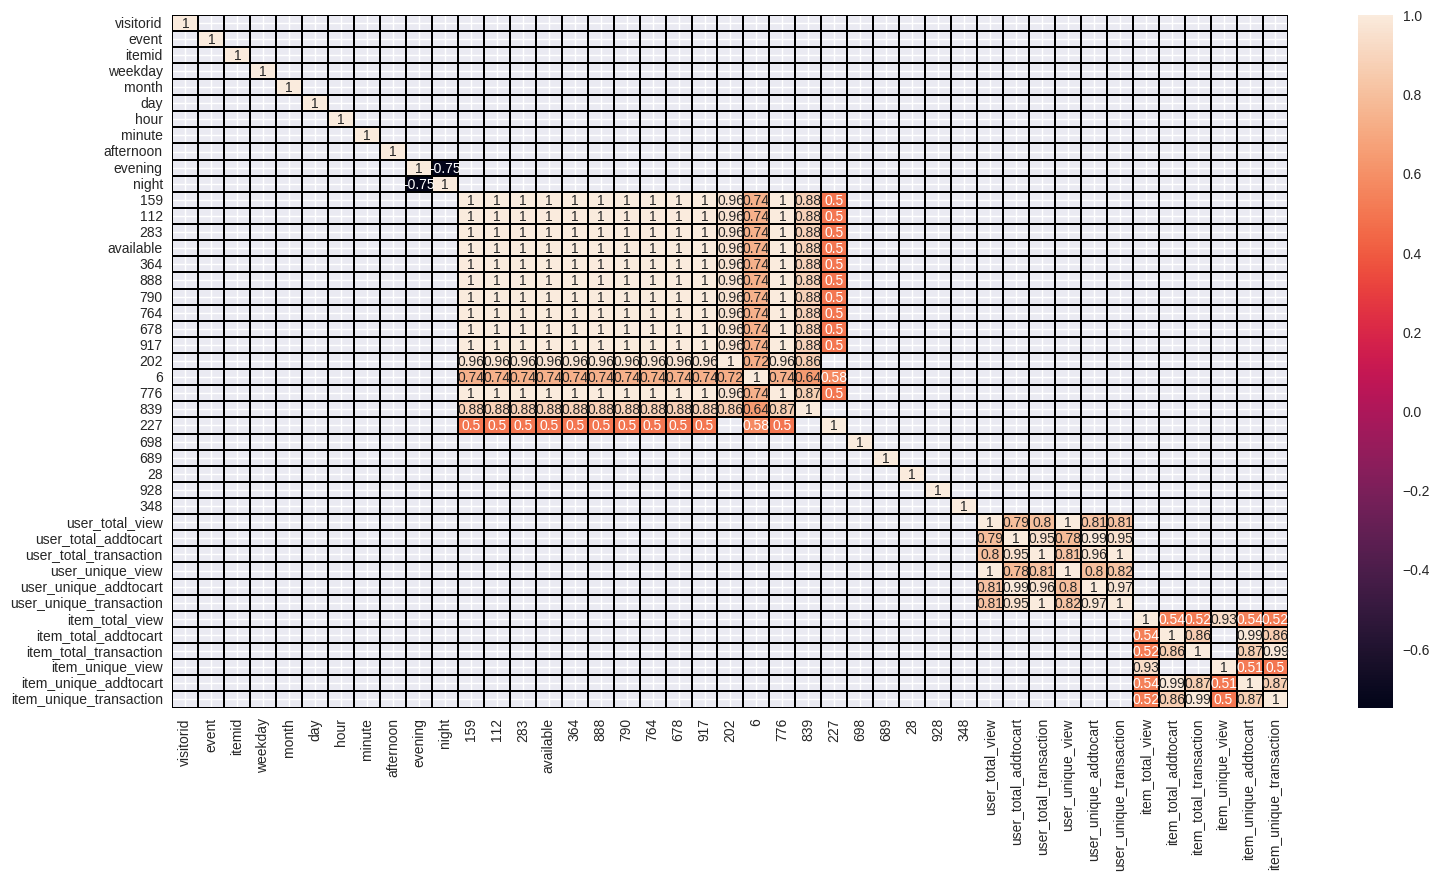

In [ ]:
# проверим корреляцию признаков
corr = round(train.corr(method = 'spearman'), 2)

# выведем только данные с высоким уровнем корреляции
mask_1 = np.abs(corr) >= 0.50
mask_2 = np.abs(corr) <= -0.50
corr_data = corr[mask_1 | mask_2]

# визуализируем
fig = plt.figure(figsize = (18, 9))
sns.heatmap(corr_data, annot = True, linewidth=0.3, linecolor='black');

Снижаем размерность коррелирующих временных факторов:

In [ ]:
# определяем коррелирующие колонки
corr_features = ['evening','night']

# снижаем размерность
time_pca = PCA(n_components = 0.8)
pca_components = time_pca.fit_transform(train[corr_features])

# выводим информацию
print(
    'Количество новых компонент:',
    len(time_pca.explained_variance_ratio_)
)
print(
    'Информативность новых компонент:',
    np.round(np.sum(time_pca.explained_variance_ratio_), 4)
)

Количество новых компонент: 1
Информативность новых компонент: 0.8743


In [ ]:
# добавляем новые факторы
train['time_feature'] = pca_components
test['time_feature'] = time_pca.transform(test[corr_features])

# удаляем старые факторы
train.drop(corr_features, axis = 1, inplace = True)
test.drop(corr_features, axis = 1, inplace = True)

Снижаем размерность коррелирующих свойств товаров:



In [ ]:
# определяем коррелирующие колонки
corr_features = [
    '159', '112', '283', 'available', '364', '888', '790',
    '764', '678', '917', '202', '6', '776', '839', '227'
]

# снижаем размерность
property_pca = PCA(n_components = 0.8)
pca_components = property_pca.fit_transform(train[corr_features])

# выводим информацию
print(
    'Количество новых компонент:',
    len(property_pca.explained_variance_ratio_)
)
print(
    'Информативность новых компонент:',
    np.round(np.sum(property_pca.explained_variance_ratio_), 4)
)

Количество новых компонент: 1
Информативность новых компонент: 0.8291


In [ ]:
# добавляем новые факторы
train['property_feature'] = pca_components
test['property_feature'] = property_pca.transform(test[corr_features])

# удаляем старые факторы
train.drop(corr_features, axis = 1, inplace = True)
test.drop(corr_features, axis = 1, inplace = True)

Снижаем размерность коррелирующих user факторов:

In [ ]:
# определяем коррелирующие колонки
corr_features = [
    'user_total_view', 'user_total_addtocart', 'user_total_transaction',
    'user_unique_view', 'user_unique_addtocart', 'user_unique_transaction'
]

# снижаем размерность
user_pca = PCA(n_components = 0.8)
pca_components = user_pca.fit_transform(train[corr_features])

# выводим информацию
print(
    'Количество новых компонент:',
    len(user_pca.explained_variance_ratio_)
)
print(
    'Информативность новых компонент:',
    np.round(np.sum(user_pca.explained_variance_ratio_), 4)
)

Количество новых компонент: 1
Информативность новых компонент: 0.9924


In [ ]:
# добавляем новые факторы
train['user_feature'] = pca_components
test['user_feature'] = user_pca.transform(test[corr_features])

# удаляем старые факторы
train.drop(corr_features, axis = 1, inplace = True)
test.drop(corr_features, axis = 1, inplace = True)

Снижаем размерность коррелирующих item факторов:

In [ ]:
# определяем коррелирующие колонки
corr_features = [
    'item_total_view', 'item_total_addtocart', 'item_total_transaction',
    'item_unique_view', 'item_unique_addtocart', 'item_unique_transaction'
]

# снижаем размерность
item_pca = PCA(n_components = 0.8)
pca_components = item_pca.fit_transform(train[corr_features])

# выводим информацию
print(
    'Количество новых компонент:',
    len(item_pca.explained_variance_ratio_)
)
print(
    'Информативность новых компонент:',
    np.round(np.sum(item_pca.explained_variance_ratio_), 4)
)

Количество новых компонент: 1
Информативность новых компонент: 0.9767


In [ ]:
# добавляем новые факторы
train['item_feature'] = pca_components
test['item_feature'] = item_pca.transform(test[corr_features])

# удаляем старые факторы
train.drop(corr_features, axis = 1, inplace = True)
test.drop(corr_features, axis = 1, inplace = True)

## Визуализация данных

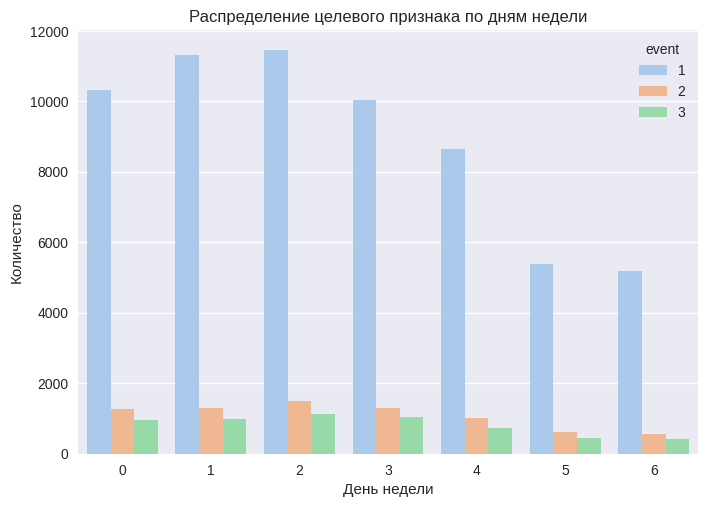

In [ ]:
countplot = sns.countplot(
    data = train,
    x = 'weekday',
    hue = 'event',
    palette = 'pastel'
)
countplot.set_title('Распределение целевого признака по дням недели')
countplot.set_xlabel('День недели')
countplot.set_ylabel('Количество');

Активность снижается по субботам и воскресеньям.

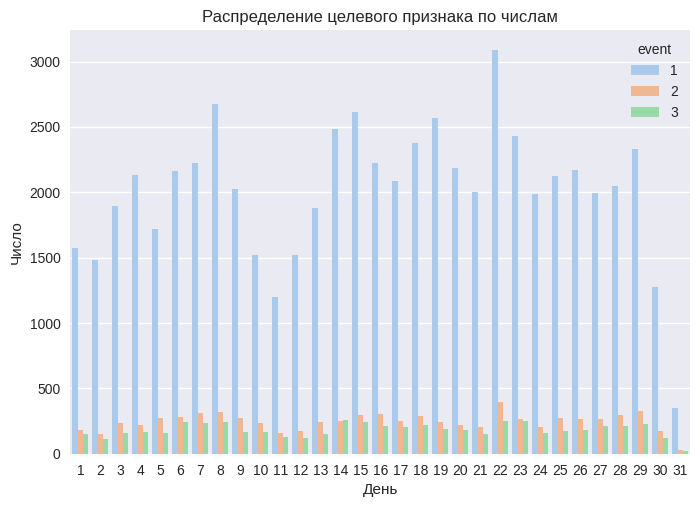

In [ ]:
countplot = sns.countplot(
    data = train,
    x = 'day',
    hue = 'event',
    palette = 'pastel'
)
countplot.set_title('Распределение целевого признака по числам')
countplot.set_xlabel('День')
countplot.set_ylabel('Число');

Прослеживается некоторая зависимость от числа.

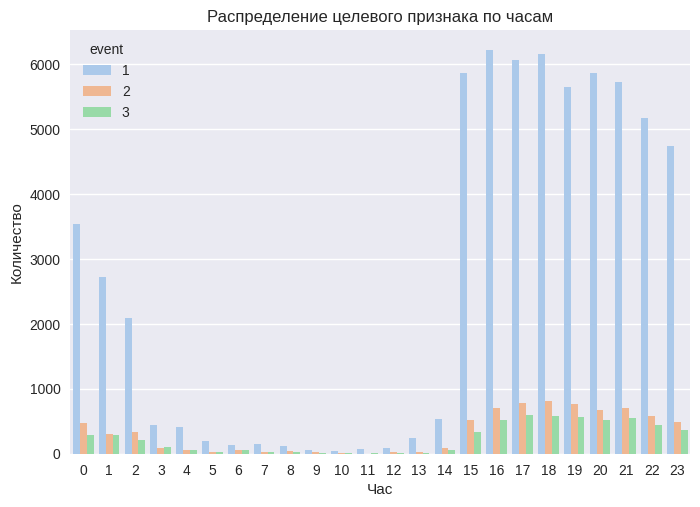

In [ ]:
countplot = sns.countplot(
    data = train,
    x = 'hour',
    hue = 'event',
    palette = 'pastel'
)
countplot.set_title('Распределение целевого признака по часам')
countplot.set_xlabel('Час')
countplot.set_ylabel('Количество');

Основная часть событий происходит в период с 15 часов до полуночи.

## Проведение экспериментов

### Коллаборативная фильтрация
Классы в библиотеке surprise умеют принимать формат только определённого типа, поэтому для этого создаём новые таблицы. Будем воспринимать колонку event как оценку - чем выше значение тем лучше. Оставим только максимальное значение для каждой пары user-item.

In [ ]:
train_dataset = train.groupby(
    ['visitorid', 'itemid'], as_index = False
)['event'].max()
test_dataset = test.groupby(
    ['visitorid', 'itemid'], as_index = False
)['event'].max()
dataset = pd.concat([train_dataset, test_dataset]).rename(
    {'visitorid': 'uid', 'itemid': 'iid'}
)
dataset.head()

,visitorid,itemid,event
0,4101,104752,3
1,4101,115244,1
2,4101,170353,3
3,4101,204798,1
4,4101,228066,3


Классы в surprise принимают данные через свой отдельный класс Dataset, в который мы отправляем данные и класс Reader с указанным диапазоном допустимых оценок:

In [ ]:
reader = Reader(rating_scale = (1.0, 3.0))
data = Dataset.load_from_df(dataset, reader)
trainset, testset = surprise.model_selection.train_test_split(
    data,
    test_size = 0.3,
    shuffle = False
)

Реализация классической коллаборативной фильтрации находится в классе KNNWithMeans, будем использовать её:

In [ ]:
algo = KNNWithMeans(
    k = 50,
    sim_options = {'name': 'pearson_baseline', 'user_base': True}
)
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


Делаем предсказание на тестовом датасете:

In [ ]:
test_pred = algo.test(testset)

Рассчитываем метрику:

In [ ]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls


precisions, recalls = precision_recall_at_k(test_pred, k=3, threshold=1.5)

# Precision and recall can then be averaged over all users
avg_precision = sum(prec for prec in precisions.values()) / len(precisions)
print('Collaborative filtering mean Precision@3:', round(avg_precision, 4))

Collaborative filtering mean Precision@3: 0.1073


### Факторизационные машины
Преобразуем целевую переменную в бинарный вид: условимся, что продукт, который пользователь положил в корзину или купил, считаются понравившимися ему (класс 1), в противном случае — не понравившимися (класс 0):

In [ ]:
train_dataset['score'] = (train_dataset['event'] > 1).apply(int)
test_dataset['score'] = (test_dataset['event'] > 1).apply(int)

# создаём user-item таблицы для тренировочной и тестовой выборок
train_pivot = pd.pivot_table(
    train_dataset,
    index = 'visitorid',
    columns = 'itemid',
    values = 'score'
)
test_pivot = pd.pivot_table(
    test_dataset,
    index = 'visitorid',
    columns = 'itemid',
    values = 'score'
)

print('Train shape:', train_pivot.shape)
print('Test shape:', test_pivot.shape)

Train shape: (371, 20245)
Test shape: (249, 10859)


In [ ]:
# создаём сводную таблицу
shell = pd.pivot_table(
    pd.concat([train_dataset, test_dataset]),
    index = 'visitorid',
    columns = 'itemid',
    values = 'score',
    aggfunc = lambda x: 0  # заполняем ячейки нулями
)
shell.tail()

itemid,15,17,19,25,42,66,124,147,168,199,...,466688,466710,466740,466747,466757,466759,466796,466843,466861,466864
visitorid,,,,,,,,,,,,,,,,,,,,,
1376763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1385073,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1390675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1398978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1403769,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Чтобы получить тренировочную и тестовую user-item таблицы, нам осталось только сложить таблицу shell с соответствующими таблицами train_pivot и test_pivot.

Чтобы корректно обрабатывать пропущенные значения, мы трансформируем 1 в 2, а 0 — в 1. Сами пропуски заполняем нулями. В результате у нас получатся две таблицы, в которых на пересечении пользователя и продукта стоит:
* 0 — если пользователь не видел этот продукт (не кликал);
* 1 — если пользователь видел этот продукт (view);
* 2 — если пользователь приобрёл или хотя бы положил в корзину этот продукт.


In [ ]:
train_pivot = shell + train_pivot
test_pivot = shell + test_pivot

train_pivot = (train_pivot + 1).fillna(0)
test_pivot = (test_pivot + 1).fillna(0)
print('Train shape:', train_pivot.shape)
print('Test shape:', test_pivot.shape)

train_pivot.tail()

Train shape: (499, 25787)
Test shape: (499, 25787)


itemid,15,17,19,25,42,66,124,147,168,199,...,466688,466710,466740,466747,466757,466759,466796,466843,466861,466864
visitorid,,,,,,,,,,,,,,,,,,,,,
1376763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1385073,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1390675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1398978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1403769,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Финальный шаг предобработки: представим user-item матрицы в виде разреженных матриц. Для получения разреженной матрицы используется функция csr_matrix() из модуля sparse библиотеки scipy:

In [ ]:
train_pivot_sparse = scipy.sparse.csr_matrix(train_pivot.values)
test_pivot_sparse = scipy.sparse.csr_matrix(test_pivot.values)

Обучим факторизационные машины с 10-ю факторами, в качестве функции потерь используем logloss, параметр random_state установим в значение 42. Обучение будем производить на 30 итерациях (эпохах):

In [ ]:
model = LightFM(no_components = 10, loss = 'logistic', random_state = 42)
model.fit(train_pivot_sparse, epochs = 30)

Рассчитаем средний precision для топ 3 рекомендуемых фильмов по всей тестовой выборке. Для этого можно воспользоваться функцией precision_at_k() из библиотеки lightfm. Результатом будет значение precision@k для каждого из пользователей.

Чтобы получить интересующий нас результат, нужно вычислить среднее:

In [ ]:
avg_precision = precision_at_k(model, test_pivot_sparse, k = 3).mean()
print('Factoring machines mean Precision@3:', round(avg_precision, 4))

Factoring machines mean Precision@3: 0.0857


### XGBoost

In [ ]:
xgb_train = train.copy()
xgb_test = test.copy()

Преобразуем целевую переменную в бинарный вид:

In [ ]:
xgb_train['score'] = (xgb_train['event'] > 1).apply(int)
xgb_test['score'] = (xgb_test['event'] > 1).apply(int)

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [ ]:
# разделим тестовую выборку на тестовую и валидационную
xgb_test, xgb_valid = sklearn.model_selection.train_test_split(
    xgb_test,
    test_size = 0.5,
    shuffle = False
)

# отделяем признаки от целевой переменной
X_train = xgb_train.drop(['visitorid', 'event', 'itemid', 'score'], axis = 1)
y_train = xgb_train['score']
X_test = xgb_test.drop(['visitorid', 'event', 'itemid', 'score'], axis = 1)
y_test = xgb_test['score']
X_valid = xgb_valid.drop(['visitorid', 'event', 'itemid', 'score'], axis = 1)

# создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(
    X_train,
    label = y_train,
    feature_names = list(X_train.columns)
)
dtest = xgb.DMatrix(
    X_test,
    label = y_test,
    feature_names = list(X_test.columns)
)
dvalid = xgb.DMatrix(X_valid, feature_names = list(X_valid.columns))

Передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры и обучаем модель XGBoost.

In [ ]:
# гиперпараметры модели
xgb_pars = {
    'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9,
    'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1,
    'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
}

# тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dtest, 'test')]

# обучаем модель XGBoost
model = xgb.train(
    params = xgb_pars,           # гиперпараметры модели
    dtrain = dtrain,             # обучающая выборка
    num_boost_round = 300,       # количество моделей в ансамбле
    evals = watchlist,           # выборки, на которых считается матрица
    early_stopping_rounds = 20,  # раняя остановка
    maximize = False,            # смена поиска максимума на минимум
    verbose_eval = 10            # шаг, через который происходит отображение метрик
)

[0]	train-rmse:0.37410	test-rmse:0.40165
[10]	train-rmse:0.34887	test-rmse:0.51545
[20]	train-rmse:0.34201	test-rmse:0.58565


In [ ]:
# делаем предсказание на тестовом наборе данных
xgb_valid['pred'] = model.predict(dvalid)

Рассчитываем средний Precision@3:

In [ ]:
user_precisions = []

for user in xgb_valid['visitorid'].unique():
    user_precisions.append(
        xgb_valid[xgb_valid['visitorid'] == user]
        .sort_values('pred', ascending = False)
        .drop_duplicates('itemid')
        .score[:3]
        .sum() / 3
)

avg_precision = np.mean(np.array(user_precisions))
print('XGBoost mean Precision@3:', round(avg_precision, 4))

XGBoost mean Precision@3: 0.2642


В результате проведения трёх экспериментов побеждает XGBoost:
* Collaborative filtering mean Precision@3: 0.1073
* Factoring machines mean Precision@3: 0.0857
* XGBoost mean Precision@3: 0.2642

Визуализируем важность факторов в виде столбчатой диаграммы:

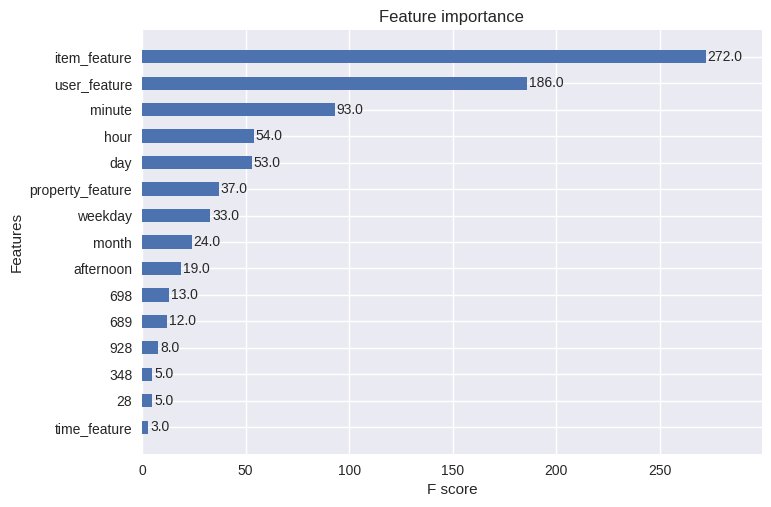

In [ ]:
xgb.plot_importance(model, height = 0.5);

## Подготовка к созданию сервиса

In [ ]:
# сохраняем обученную модель в файл
joblib.dump(model, 'xgb_model')

['xgb_model']

In [ ]:
# сохраняем обученный PCA для временных признаков
joblib.dump(time_pca, 'time_pca')

['time_pca']

In [ ]:
# посмотрим какое значение выдаёт user_pca для новых посетителей
test_df = pd.DataFrame([{
    'user_total_view': 0,
    'user_total_addtocart': 0,
    'user_total_transaction': 0,
    'user_unique_view': 0,
    'user_unique_addtocart': 0,
    'user_unique_transaction': 0
}])
test_df['user_feature'] = user_pca.transform(test_df)
test_df['user_feature']

,user_feature
0,-1189.36843


Подготавливаем датасет событий для нашего сервиса. На этот раз не будем удалять малоактивных пользователей.

In [ ]:
# загружаем полный датасет
events = pd.read_csv('/content/drive/MyDrive/events.csv')

# кодируем события
events['event'] = events['event'].apply(encode_event)

# переводим временную метку к формату datetime
events['timestamp'] = pd.to_datetime(events['timestamp'], unit = 'ms')

# создаём временные признаки
events['weekday'] = events['timestamp'].dt.weekday
events['month'] = events['timestamp'].dt.month
events['day'] = events['timestamp'].dt.day
events['hour'] = events['timestamp'].dt.hour
events['minute'] = events['timestamp'].dt.minute
events['day_period'] = events['hour'].apply(get_time_period)
events = pd.get_dummies(events, prefix = '', prefix_sep = '', dtype = 'int')

# удаляем дубликаты
events.drop_duplicates(subset_cols, inplace = True)

# удаляем неинформативный признак
events = events.drop('transactionid', axis = 1)

# добавляем список свойств в датасет
events = pd.merge(events, property_lists, how = 'left', on = 'itemid')
events['property'].fillna('[]', inplace = True)

# кодируем признаки
for value in top_properties.index:
    events[value] = (
        events['property']
        .apply(lambda x: 1 if value in x else 0)
    )

# удаляем признак со списками
events.drop('property', axis = 1, inplace = True)

# общие количества просмотров, добавлений в корзину и покупок
user_total_view = (
    events[events['event'] == 1]
    .groupby('visitorid', as_index = False)['itemid']
    .count()
    .rename(columns = {'itemid': 'user_total_view'})
)
user_total_addtocart = (
    events[events['event'] == 2]
    .groupby('visitorid', as_index = False)['itemid']
    .count()
    .rename(columns = {'itemid': 'user_total_addtocart'})
)
user_total_transaction = (
    events[events['event'] == 3]
    .groupby('visitorid', as_index = False)['itemid']
    .count()
    .rename(columns = {'itemid': 'user_total_transaction'})
)

# количества уникальных просмотров, добавлений в корзину и покупок
user_unique_view = (
    events[events['event'] == 1]
    .groupby('visitorid', as_index = False)['itemid']
    .nunique()
    .rename(columns = {'itemid': 'user_unique_view'})
)
user_unique_addtocart = (
    events[events['event'] == 2]
    .groupby('visitorid', as_index = False)['itemid']
    .nunique()
    .rename(columns = {'itemid': 'user_unique_addtocart'})
)
user_unique_transaction = (
    events[events['event'] == 3]
    .groupby('visitorid', as_index = False)['itemid']
    .nunique()
    .rename(columns = {'itemid': 'user_unique_transaction'})
)

# объединяем в одну таблицу
user_statistics = pd.merge(
    user_total_view,
    user_total_addtocart,
    how = 'outer',
    on = 'visitorid'
)
user_statistics = pd.merge(
    user_statistics,
    user_total_transaction,
    how = 'outer',
    on = 'visitorid'
)
user_statistics = pd.merge(
    user_statistics,
    user_unique_view,
    how = 'outer',
    on = 'visitorid'
)
user_statistics = pd.merge(
    user_statistics,
    user_unique_addtocart,
    how = 'outer',
    on = 'visitorid'
)
user_statistics = pd.merge(
    user_statistics,
    user_unique_transaction,
    how = 'outer',
    on = 'visitorid'
)

# заполняем пропуски нулями и меняем тип
user_statistics.fillna(0, inplace = True)
user_statistics = user_statistics.astype(int)

# добавляем user факторы
events = pd.merge(events, user_statistics, how = 'left', on = 'visitorid')

# общие количества просмотров, добавлений в корзину и покупок
item_total_view = (
    events[events['event'] == 1]
    .groupby('itemid', as_index = False)['visitorid']
    .count()
    .rename(columns = {'visitorid': 'item_total_view'})
)
item_total_addtocart = (
    events[events['event'] == 2]
    .groupby('itemid', as_index = False)['visitorid']
    .count()
    .rename(columns = {'visitorid': 'item_total_addtocart'})
)
item_total_transaction = (
    events[events['event'] == 3]
    .groupby('itemid', as_index = False)['visitorid']
    .count()
    .rename(columns = {'visitorid': 'item_total_transaction'})
)

# количества уникальных просмотров, добавлений в корзину и покупок
item_unique_view = (
    events[events['event'] == 1]
    .groupby('itemid', as_index = False)['visitorid']
    .nunique()
    .rename(columns = {'visitorid': 'item_unique_view'})
)
item_unique_addtocart = (
    events[events['event'] == 2]
    .groupby('itemid', as_index = False)['visitorid']
    .nunique()
    .rename(columns = {'visitorid': 'item_unique_addtocart'})
)
item_unique_transaction = (
    events[events['event'] == 3]
    .groupby('itemid', as_index = False)['visitorid']
    .nunique()
    .rename(columns = {'visitorid': 'item_unique_transaction'})
)

# объединяем в одну таблицу
item_statistics = pd.merge(
    item_total_view,
    item_total_addtocart,
    how = 'outer',
    on = 'itemid'
)
item_statistics = pd.merge(
    item_statistics,
    item_total_transaction,
    how = 'outer',
    on = 'itemid'
)
item_statistics = pd.merge(
    item_statistics,
    item_unique_view,
    how = 'outer',
    on = 'itemid'
)
item_statistics = pd.merge(
    item_statistics,
    item_unique_addtocart,
    how = 'outer',
    on = 'itemid'
)
item_statistics = pd.merge(
    item_statistics,
    item_unique_transaction,
    how = 'outer',
    on = 'itemid'
)

# заполняем пропуски нулями и меняем тип
item_statistics.fillna(0, inplace = True)
item_statistics = item_statistics.astype(int)

# добавляем item факторы
events = pd.merge(events, item_statistics, how = 'left', on = 'itemid')

# удаляем неинформативные признаки
events = events.drop(low_information_cols, axis = 1)

# преобразуем коррелирующие временные признаки
corr_features = ['evening','night']
events['time_feature'] = time_pca.transform(events[corr_features])
events.drop(corr_features, axis = 1, inplace = True)

# преобразуем коррелирующие признаки свойств продуктов
corr_features = [
    '159', '112', '283', 'available', '364', '888', '790',
    '764', '678', '917', '202', '6', '776', '839', '227'
]
events['property_feature'] = property_pca.transform(events[corr_features])
events.drop(corr_features, axis = 1, inplace = True)

# преобразуем коррелирующие клиентские статистики
corr_features = [
    'user_total_view', 'user_total_addtocart', 'user_total_transaction',
    'user_unique_view', 'user_unique_addtocart', 'user_unique_transaction'
]
events['user_feature'] = user_pca.transform(events[corr_features])
events.drop(corr_features, axis = 1, inplace = True)

# преобразуем коррелирующие продуктовые статистики
corr_features = [
    'item_total_view', 'item_total_addtocart', 'item_total_transaction',
    'item_unique_view', 'item_unique_addtocart', 'item_unique_transaction'
]
events['item_feature'] = item_pca.transform(events[corr_features])
events.drop(corr_features, axis = 1, inplace = True)

Сохраняем подготовленный датасет в csv файл:

In [ ]:
events.to_csv('events_featured.csv', index = False)

Проверяем как работает модель на полном датасете.

In [ ]:
# подготавливаем формат
events_copy = events.copy()
events_copy['score'] = (events_copy['event'] > 1).apply(int)
X_events = events_copy.drop(['visitorid', 'event', 'itemid', 'score'], axis = 1)
devents = xgb.DMatrix(X_events, feature_names = list(X_events.columns))

# делаем предсказания
events_copy['pred'] = model.predict(devents)

Рассчитываем Precision@3 для каждого пользователи и вычисляем средний показатель по всем.

In [ ]:
events_precisions = []

for user in events_copy['visitorid'].unique():
    events_precisions.append(
        events_copy[events_copy['visitorid'] == user]
        .sort_values('pred', ascending = False)
        .drop_duplicates('itemid')
        .score[:3]
        .sum() / 3
)

avg_prec = np.mean(np.array(events_precisions))
print('XGBoost mean Precision@3:', round(avg_prec, 4))

XGBoost mean Precision@3: 0.0053


Всего 0.53 %, но дело в том, что большенство пользователей ничего не покупало, а наши рекоммендации мы им ещё не показали:

In [ ]:
print(
    'Доля посетителей, что либо купивших или хотя бы положивших продукт в корзину:',
    round(
        events_copy[events_copy['score'] == 1]['visitorid'].nunique()
        / events_copy['visitorid'].nunique(), 4
    )
)

Доля посетителей, что либо купивших или хотя бы положившик продукт в корзину: 0.0276


Если отсортировать датасет по сделанным предсказаниям, то всё выглядит веселее:

In [ ]:
events_copy.sort_values('pred', ascending = False).head(60)

,visitorid,event,itemid,weekday,month,day,hour,minute,afternoon,698,689,28,928,348,time_feature,property_feature,user_feature,item_feature,score,pred
2465543,277114,2,72345,2,7,22,13,33,1,0,0,0,1,1,-0.235197,0.269587,-1186.462123,-13.271241,1,0.977514
1771439,1054066,2,344730,1,5,19,15,35,1,1,1,0,0,0,-0.235197,-0.266258,-1188.753709,-13.271241,1,0.962717
1781362,1054066,2,103397,1,5,19,15,36,1,1,1,0,0,0,-0.235197,-0.266258,-1188.753709,-13.271241,1,0.962717
2460243,766104,2,224340,2,7,22,5,35,0,0,1,1,1,0,-0.235197,0.269587,-1184.531292,-13.271241,1,0.957080
1640495,859452,2,381109,2,5,13,22,16,0,0,1,1,0,0,-0.901439,0.269587,-1188.907389,-13.271241,1,0.956721
372359,585985,2,34307,5,6,20,1,20,0,0,1,1,1,0,-0.901439,0.269587,-1185.474889,-13.271241,1,0.955932
1395171,487947,2,428851,1,9,15,3,17,0,0,1,1,1,0,-0.235197,0.269587,-1186.769483,-13.271241,1,0.955932
1025915,1306530,2,196500,1,8,25,21,28,0,0,1,1,1,0,0.510539,0.269587,-1183.429370,-13.271241,1,0.944884
2377245,611139,2,428690,5,7,18,3,25,0,0,0,1,1,1,-0.235197,0.269587,-1185.106236,-13.271241,1,0.944604
692982,710424,2,129839,3,8,6,23,22,0,0,1,1,1,0,-0.901439,0.269587,-1183.988918,-13.271241,1,0.939650
